In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from tqdm.auto import trange 

import ssm
from ssm.messages import hmm_sample

from joblib import Parallel, delayed
import multiprocessing
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
print('Parallel processing with '+str(NumThread)+' cores')

from util_factorial_hmm import gibbs

Parallel processing with 18 cores


# Sample synthetic data

In [8]:
num_factors = 3
num_states = 2
emission_dim = 10

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)

num_timesteps = 5000

initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrix = 0.9 * np.eye(num_states) + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))

means = 3 * npr.randn(num_factors, num_states, emission_dim)
# means = np.zeros((num_factors, num_states, emission_dim))
# means[1] = npr.gamma(10.0, 1.0, size=(num_states, emission_dim))
# variances = 0.1 * np.ones((num_factors, num_states, emission_dim))
variances=0.5*np.ones(emission_dim)

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(variances) * npr.randn(emission_dim)

(300.0, 500.0)

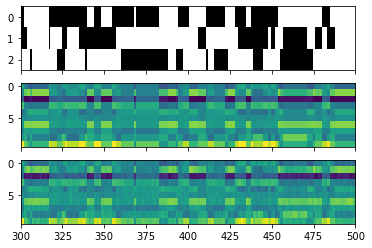

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 500)

# Inference via Gibbs sampling

Let $z_{t,h} \in \{1,\ldots,K\}$ be the state of factor $h$ at time $t$. The emissions are,

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sum_h \sigma_{h,z_{t,h},n}^2)
\end{align}

However, we restrict to a simpler model where *all states from all factors* share the same variance $\sigma_{h,z_{t,h},n}^2=\sigma_{n}^2$

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sigma_{n}^2)
\end{align}

We perform inference following (Ghahramani and Jordan, 1997), where we use Gibbs sampling to estimate the posterior probabilities, but an exact M-step to obtain the parameters from the posterior probabilities. See Murphy "Machine Learning" book for a variational mean field approximation. 


In [10]:
npr.seed(112)
nruns=5
ll_tot=[]
params_tot=[]
samples_tot=[]
for i_runs in range(nruns):
          initial_states = np.zeros((num_timesteps, num_factors), dtype=int)
          # initialize parameters randomly
          transition_probs=[]
          initial_dist = np.ones((num_factors, num_states)) / num_states
          init_transition_matrix = 0.8 * np.eye(num_states) + 0.2 * np.roll(np.eye(num_states), 1, axis=1)
          init_transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))
          init_emission_means = npr.rand(num_factors, num_states, emission_dim)
          init_variances=np.ones(emission_dim)
          initial_params=dict(transition_matrices=init_transition_matrices,
                    means=init_emission_means,
                    variances=init_variances,
                    initial_dist=initial_dist)
          options=dict(num_runs=10, # iterations of the Gibbs-Maximization loop
                    num_gibbs=NumThread, # samples of Gibbs collected to estimate posterior probs
                    num_iters=10, # iterations of gibbs sampling for convergence of a state sequence
                    parallel=True)  # parallelize on num_gibbs

          samples, params_samples, lls, _ = gibbs(initial_states, emissions, initial_params, hypers, options)

          # samples, params_samples = gibbs(true_states, emissions, initial_params, hypers, options)

          ll_tot.append(lls[-1]/num_timesteps)
          samples_tot.append(samples[-1][0])
          params_tot.append(params_samples[-1])


bestfit=np.argmax(ll_tot)
print('Final: best fit at run '+str(bestfit)+'with ll='+str(ll_tot[bestfit]))
params_fit=params_tot[bestfit]
samples_fit=samples_tot[bestfit]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Final: best fit at run 0with ll=2.5283258358913203


True  [[[0.9 0.1]
  [0.1 0.9]]

 [[0.9 0.1]
  [0.1 0.9]]

 [[0.9 0.1]
  [0.1 0.9]]]
Inferred  [[[0.89619943 0.09952978]
  [0.10380057 0.90047022]]

 [[0.89824121 0.09306779]
  [0.10217755 0.90654921]]

 [[0.90617482 0.09341317]
  [0.09422614 0.90618762]]]


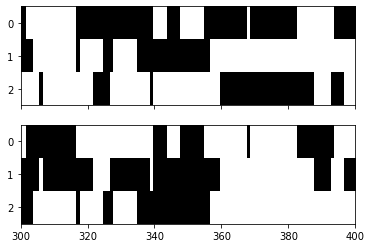

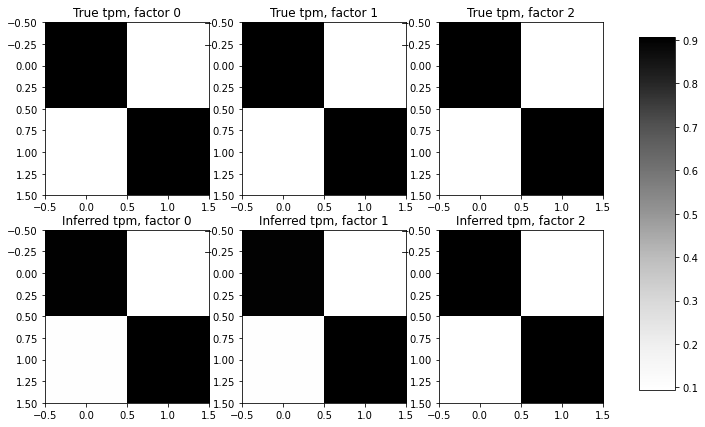

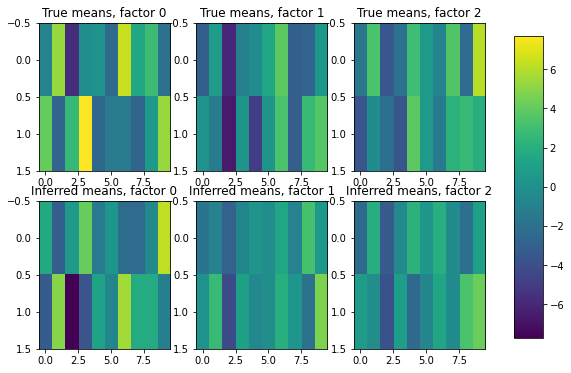

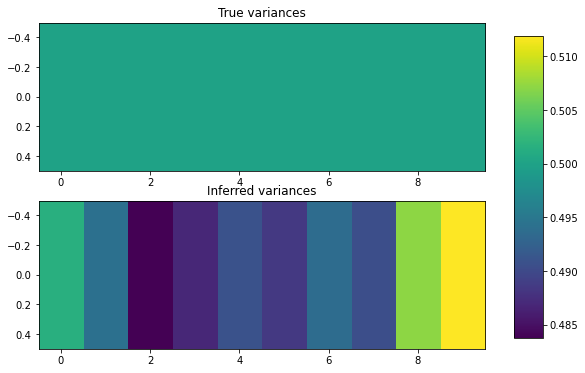

Text(0, 0.5, 'LL')

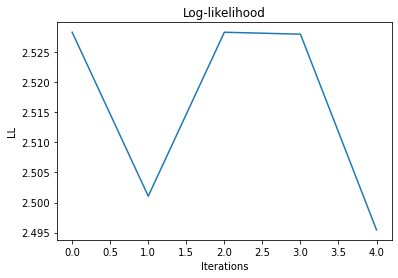

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(samples_fit.T, aspect="auto", interpolation="none", cmap="Greys")
plt.xlim(300, 400)

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = num_factors
values=[params['transition_matrices'].flatten(),params_fit['transition_matrices'].flatten()]
vmin=np.min(values); vmax=np.max(values)
for h in range(num_factors):
          fig.add_subplot(rows, columns, h+1)
          im=plt.imshow(params['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("True tpm, factor "+str(h))
          fig.add_subplot(rows, columns, h+num_factors+1)
          im=plt.imshow(params_fit['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("Inferred tpm, factor "+str(h))
print('True ',params['transition_matrices'])
print('Inferred ',params_fit['transition_matrices'])
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

vmin=np.min([params['means'].flatten(),params_fit['means'].flatten()]); vmax=np.max([params['means'].flatten(),params_fit['means'].flatten()])
fig=plt.figure(figsize=(8,6))
for h in range(num_factors):
          ax = plt.subplot(rows, columns, h+1)
          im=ax.imshow(params['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          # print('True means factor '+str(h)+' ',str(params['means'][h]))
          ax.set_title("True means, factor "+str(h))
          ax = plt.subplot(rows, columns, h+1+num_factors)
          im=ax.imshow(params_fit['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          # print('Inferred means factor '+str(h)+' ',str(params_fit['means'][h]))
          ax.set_title("Inferred means, factor "+str(h))
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

values=[params['variances'].flatten(),params_fit['variances'].flatten()]
vmin=np.min(values); vmax=np.max(values)
fig=plt.figure(figsize=(8,6))
ax = plt.subplot(2, 1, 1)
im=ax.imshow(np.expand_dims(params['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
# print('True variances '+str(params['variances']))
ax.set_title("True variances")
ax = plt.subplot(2,1,2)
im=ax.imshow(np.expand_dims(params_fit['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
# print('Inferred variances '+str(params_fit['variances']))
ax.set_title("Inferred variances")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

fig=plt.figure()
plt.plot(ll_tot)
plt.title('Log-likelihood')
plt.xlabel('Iterations')
plt.ylabel('LL')
